# How to use Simbad TAP Service

The Table Access Protocol ([TAP](http://www.ivoa.net/documents/TAP/)) is a way to access astronomical databases using the Astronomical Data Query Language (ADQL). The [ADQL](http://www.ivoa.net/documents/latest/ADQL.html) is a variant of SQL that supports querying grammar for astronomical operations.

[Simbad](http://simbad.u-strasbg.fr/simbad/) is a database for astronomical objects that is updated constantly from the literature. It can be accessed by various methods including TAP.

I recently wanted to
- retrieve all related bibliography for a set of objects
- get all radial velocity measurements for a set of objects

It turns out this is fairly simple with [pyvo](#) and ADQL.

Pyvo provides a collection of python modules related to [Virtual observatory](https://en.wikipedia.org/wiki/Virtual_observatory). For Simbad, we can simply create an instance of its `vo.dal.TAPService` class with the `baseurl` set to TAP endpoint.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("seaborn-talk")
import pandas as pd
import numpy as np

from astropy.table import Table
import pyvo as vo

In [2]:
simbadtap = vo.dal.TAPService("http://simbad.u-strasbg.fr/simbad/sim-tap")

Let's see all the available tables.

In [24]:
# get all tables
# tables method of TAPService parses the response of /tables,
# but it will result in exception due to a possible bug in astropy vo
# but you can also just query the database for this info
result = simbadtap.run_sync("select * from TAP_SCHEMA.tables where schema_name not like 'TAP_SCHEMA'")

In [26]:
print("number of tables available = {:d}".format(len(result.table)))
result.table[:5]['table_name','description']

number of tables available = 42


table_name,description
object,object
basic,General data about an astronomical object
otypes,List of all object types associated with an object
ids,all names concatenated with pipe
alltypes,all object types concatenated with pipe
otypedef,all names and definitions for the object types


## Get all identifiers of an object

## Get all velocity measurements

The relevant table for RV measurements is `mesVelocities`. We also need `ident` table which has
two columns, `oidref` and `id` where `oidref` is unique internally, and `id` is all possible known
names of sources. we use `oidref` to crossmatch tables. We can first check what columns are in `mesVelocities` and `ident` tables.

In [22]:
def pprint_columns_description(tablename):
    """Pretty print column description table"""
    rows = []
    for col in simbadtap.run_sync(
        "select top 0 * from {}".format(tablename)).table.itercols():
        rows.append([col.name, col.dtype.str, col.description])
    tt = Table(rows=rows, names=['colname', 'dtype','description'])
    return tt

In [6]:
pprint_columns_description("ident")

colname,dtype,description
str6,str3,str26
id,|O,Identifier
oidref,<i8,Object internal identifier


In [7]:
pprint_columns_description("mesVelocities")

colname,dtype,description
str14,str3,str71
bibcode,|O,measurement bibcode
d,|S1,'D' if the resolution is a conversion from the dispersion
meanError,<f4,sigma(Value)
meanError_prec,<i2,Precision (# of decimal positions) associated with the column meanError
mespos,<i2,Position of a measurement in a list of measurements
nature,|O,nature of the measurement
nbmes,<i2,Number of measurements
obsdate,<f8,Observation date
obsdate_prec,<i2,Precision (# of decimal positions) associated with the column obsdate


We will query stars by their HIP or TYC identifiers. For this, we make a table with one column (`name`), and upload this in order to crossmatch in VOTable format.

In [8]:
identable = Table.read("test.xml", format='votable')
identable[:3]

name
str15
TYC 8036-1001-1
TYC 1772-508-1
TYC 2911-1339-1


Grab `oidref` from `ident` table, and query `mesVelocities`.

In [9]:
query = """
SELECT t.name,bibcode, nbmes, obsdate, qual, quality,
    velType, velValue, velValue_prec, remark, remarks, ident.oidref
FROM TAP_UPLOAD.mytable as t
    JOIN ident ON t.name = ident.id
    JOIN mesVelocities ON mesVelocities.oidref = ident.oidref
"""

In [10]:
%%time
result = simbadtap.run_sync(query, uploads={"mytable":('inline', 'test.xml')})

CPU times: user 178 ms, sys: 11 ms, total: 189 ms
Wall time: 3.56 s


Even for about 10k stars, this is very fast. We can access `astropy.table.Table` instance of the result as `result.table`. Better yet, because I know there are multiple measurements for some stars, I can convert it to `pandas.DataFrame` for further inspection.

In [11]:
dfrv = result.table.to_pandas()
# decode all bytestrings
dfrv = dfrv.apply(lambda x: x.str.decode('utf-8') if x.dtype==object else x)

In [12]:
dfrv.groupby("quality")['name'].describe()

quality        
         count                 744
         unique                438
         top        TYC 2342-544-1
         freq                   14
A        count                 508
         unique                360
         top            HIP 107362
         freq                    6
B        count                 864
         unique                709
         top       TYC 6166-1405-1
         freq                    4
C        count                 382
         unique                313
         top        TYC 9344-293-1
         freq                    3
D        count                  89
         unique                 84
         top       TYC 8966-1241-1
         freq                    3
E        count                  31
         unique                 30
         top            HIP 109388
         freq                    2
Name: name, dtype: object

I see that there are quite a few stars with multiple quality A measurements. Let's see if they agree.

In [13]:
rvA = dfrv.loc[dfrv.quality == 'A'].groupby("name")

In [14]:
# see if multiple quality A measurements agree with each other
# make sure bibcode for the measurements are different
rvAmulti = rvA.filter(lambda x:x.bibcode.unique().size>1)
print(rvAmulti.name.unique().size)

96


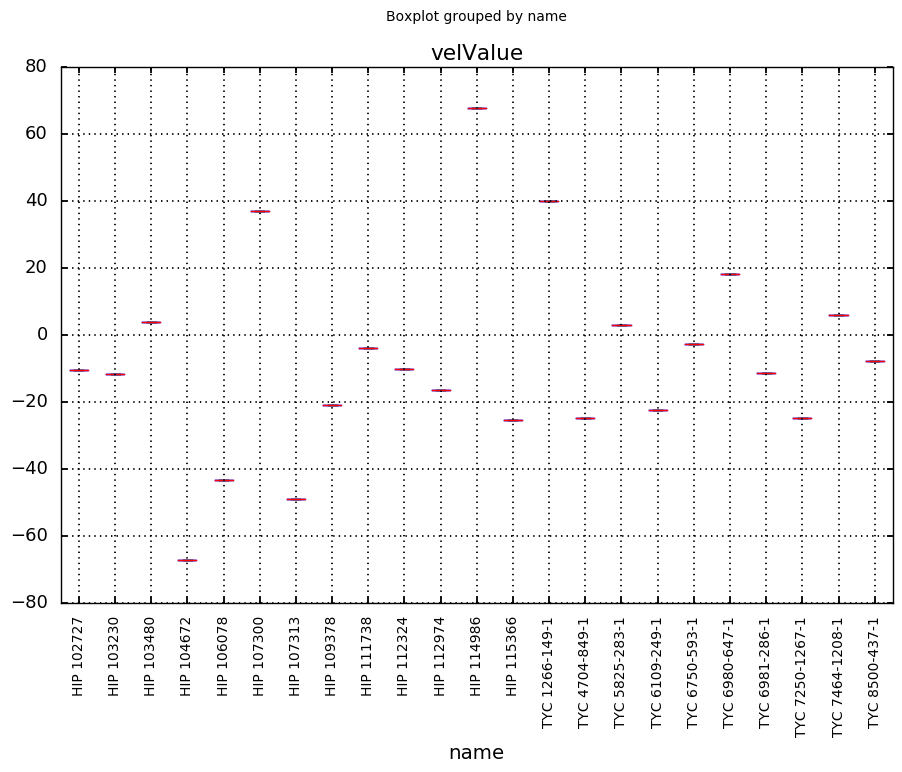

In [19]:
# undersample for presentation
rvAmulti.iloc[::10].boxplot("velValue", "name", rot=90);

..and they do for the most part!

## Get all bibliographies

Same goes for querying all bibliographies related to a set of objects.
This time, we need to query `ref` and also need `has_ref` in order to crossmatch `oidref` with `oidbibref`, which is cross-identified with `ref.oidbib`.

In [16]:
pprint_columns_description("ref")

colname,dtype,description
str9,str3,str28
bibcode,|O,Bibcode
doi,|O,DOI designation
journal,|O,Abbreviation for the journal
last_page,<i4,Last page number
nbobject,<i4,Number of objects studied in
oidbib,<i8,Bibcode internal identifier
page,<i4,page number
title,|O,Title
volume,<i4,volume number


In [17]:
pprint_columns_description('has_ref')

colname,dtype,description
str10,str3,str33
obj_freq,<i2,flag
oidbibref,<i8,Bibcode internal identifier
oidref,<i8,Object internal identifier
ref_flag,<i2,flag
ref_raw_id,|O,id like it appears in the article


In [18]:
query = """
SELECT t.name, bibcode, journal, title,  year, volume, doi
FROM TAP_UPLOAD.mytable as t
    JOIN ident ON t.name = ident.id
    JOIN has_ref ON has_ref.oidref = ident.oidref
    JOIN ref ON ref.oidbib = has_ref.oidbibref
"""